In [34]:
import pandas as pd
import numpy as np
import warnings
import geopandas as gpd
from dbfread import DBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import shap
import math
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [35]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### filter max and min of ros_p

In [36]:
#df = df[df["ros_p"] < 3000]
#df = df[df["ros_p"] > 500]

### remove nans from ros_p

In [37]:
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### convert categorical variables into "category" type

In [38]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [39]:
log_base = 10

ros_lag_cols = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in ros_lag_cols:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=ros_lag_cols, inplace=True)

### Select specific columns for modeling

In [40]:
c = [
    "gp_300_av",
    "duration_p",
    "ros_p_lg1_log",
    "rh_2m_av",
    "HDW_av",
    "ros_p"
]

df = df[c]

### Eliminate vars with >50% rows with nans

In [41]:
df = df.drop(
    columns=["EL_m_av", "Cin_av", "gT_s_9_av", "rh_700_av", "LiftIdx_av", "CBH_m_av"],
    errors="ignore"
)

### Create test and train datasets

In [ ]:
# change test_size value to change validdation dataset %
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

X_train = df_train[train_features].copy()
X_test = df_test[train_features].copy()
y_train = df_train['ros_p'].copy()
y_test = df_test['ros_p'].copy()

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# Remove invalid targets (-1 values)
valid_train = y_train != -1
valid_test = y_test != -1

X_train_final = X_train[valid_train].reset_index(drop=True)
y_train_final = y_train[valid_train].reset_index(drop=True)

X_test_final = X_test[valid_test].reset_index(drop=True)
y_test_final = y_test[valid_test].reset_index(drop=True)

# Save datasets
#X_train_final.to_csv('X_train_with_lags.csv', index=False)
#y_train_final.to_csv('y_train_with_lags.csv', index=False)
#X_test_final.to_csv('X_test_with_lags.csv', index=False)  
#y_test_final.to_csv('y_test_with_lags.csv', index=False)

Training set size: 938
Test set size: 235


### Linear Model

In [43]:
# modify constants below in order to change transformation of ros_p. (don't forget to apply the same transformation to ros_p lags above)
log_mult = 1 #23.3139 
log_base = 10 #2.9637

y_train_log = log_mult *  np.log1p(y_train_final) / np.log(log_base)
y_test_log = log_mult * np.log1p(y_test_final) / np.log(log_base)


NaN values in X_train_final: 273
NaN values in y_train_log: 0
NaN values in X_test_final: 80
Starting model training...
n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 4
max_resources_: 938
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 234
n_resources: 4
Fitting 2 folds for each of 234 candidates, totalling 468 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not w

----------
iter: 1
n_candidates: 117
n_resources: 8
Fitting 2 folds for each of 117 candidates, totalling 234 fits
----------
iter: 2
n_candidates: 59
n_resources: 16
Fitting 2 folds for each of 59 candidates, totalling 118 fits
----------
iter: 3
n_candidates: 30
n_resources: 32
Fitting 2 folds for each of 30 candidates, totalling 60 fits
----------
iter: 4
n_candidates: 15
n_resources: 64
Fitting 2 folds for each of 15 candidates, totalling 30 fits
----------
iter: 5
n_candidates: 8
n_resources: 128
Fitting 2 folds for each of 8 candidates, totalling 16 fits
----------
iter: 6
n_candidates: 4
n_resources: 256
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 7
n_candidates: 2
n_resources: 512
Fitting 2 folds for each of 2 candidates, totalling 4 fits

Search complete.
Best parameters found: {'model__alpha': np.float64(5.427446347075766), 'model__fit_intercept': True, 'model__max_iter': 2000, 'model__tol': 1e-05}

Log scale metrics:
R2 Score (log): 0.4763
RMS

/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan         

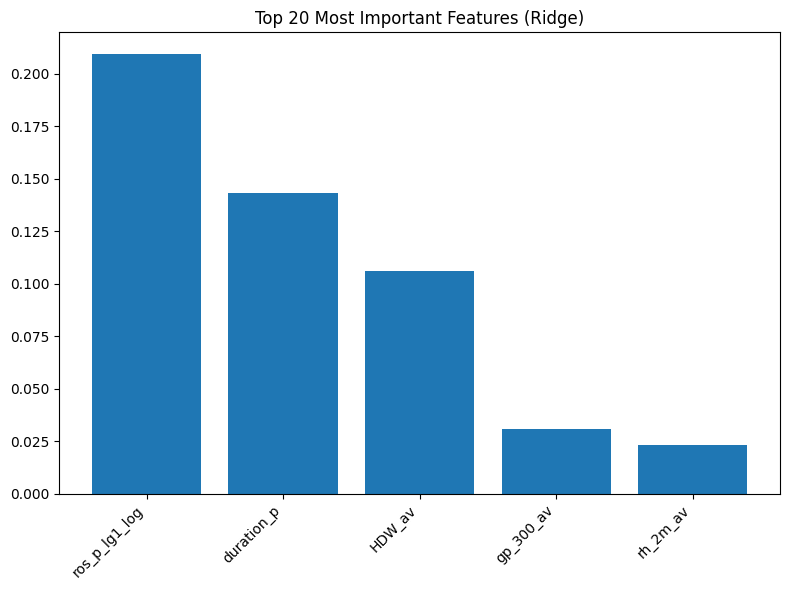


Top 20 Most Important Features (Ridge):
         feature  importance
2  ros_p_lg1_log    0.209250
1     duration_p    0.143122
4         HDW_av    0.105901
0      gp_300_av    0.030934
3       rh_2m_av    0.023336

Top 20 Coefficients (Ridge):
         feature  coefficient  abs_coefficient
2  ros_p_lg1_log     0.209250         0.209250
1     duration_p    -0.143122         0.143122
4         HDW_av     0.105901         0.105901
0      gp_300_av    -0.030934         0.030934
3       rh_2m_av    -0.023336         0.023336


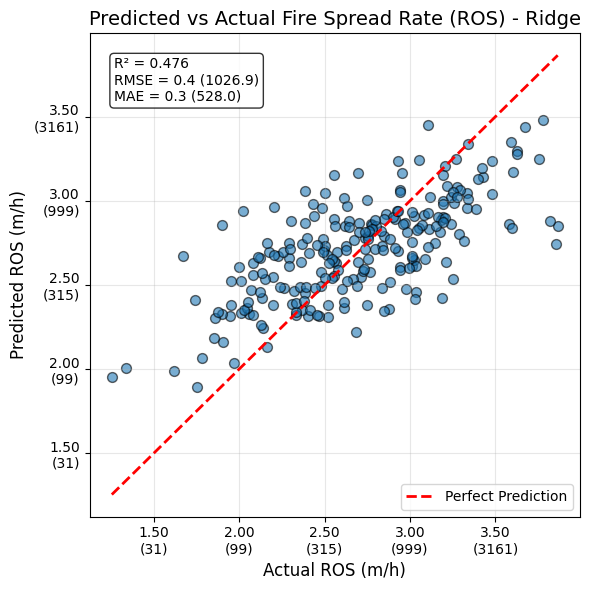

In [44]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Check for NaN values before proceeding
print(f"NaN values in X_train_final: {X_train_final.isna().sum().sum()}")
print(f"NaN values in y_train_log: {y_train_log.isna().sum() if hasattr(y_train_log, 'isna') else np.isnan(y_train_log).sum()}")
print(f"NaN values in X_test_final: {X_test_final.isna().sum().sum()}")

# Parameter distributions for different models
param_dist = {
    'model__alpha': uniform(0.001, 10),               # Regularization strength
    'model__fit_intercept': [True, False],            # Whether to calculate intercept
    'model__max_iter': [1000, 2000, 5000],           # Maximum iterations
    'model__tol': [1e-4, 1e-5, 1e-6],               # Tolerance for stopping
}

# Option 1: Linear model with imputation
base_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # Handle NaN values
    ('scaler', StandardScaler()),                     # Scale features
    ('model', Ridge(random_state=42))                 # Your linear model
])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=2)

# Halving random search
linear_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,                                         # how aggressively to cut poor performers
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model search
print("Starting model training...")
linear_random.fit(X_train_final, y_train_log)

# Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {linear_random.best_params_}")
best_model = linear_random.best_estimator_

# Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Inverse transform log to linear
inv_mult = np.log(log_base) / log_mult
y_test_linear = np.exp(y_test_log * inv_mult) - 1
y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

# Metrics in log space
r2 = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)

# Metrics in linear space
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

# Feature importance/coefficients
feature_names = X_train_final.columns.tolist()

# Extract the actual model from the pipeline if using one
if hasattr(best_model, 'named_steps'):
    final_model = best_model.named_steps['model']
else:
    final_model = best_model

if hasattr(final_model, 'coef_'):
    # For linear models (Ridge, Lasso, ElasticNet)
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(final_model.coef_)
    })
    model_type = type(final_model).__name__
elif hasattr(final_model, 'feature_importances_'):
    # For tree-based models like RandomForest
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    })
    model_type = type(final_model).__name__
else:
    # Fallback
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': [1.0] * len(feature_names)
    })
    model_type = "Pipeline with " + type(final_model).__name__

importances = importances.sort_values('importance', ascending=False)

print("\nLog scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features ({model_type})')
plt.tight_layout()
plt.show()

print(f"\nTop 20 Most Important Features ({model_type}):")
print(importances.head(20))

# If using linear model, also show coefficients with signs
if hasattr(final_model, 'coef_'):
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': final_model.coef_,
        'abs_coefficient': np.abs(final_model.coef_)
    })
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    print(f"\nTop 20 Coefficients ({model_type}):")
    print(coefficients.head(20))

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title(f'Predicted vs Actual Fire Spread Rate (ROS) - {model_type}', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation with both log and linear scales
plt.text(0.05, 0.95, 
    f'R² = {r2:.3f}\n'
    f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
    f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Simple Linear Equation Output
print("LINEAR EQUATION FOR PREDICTING FIRE SPREAD RATE")
print("=" * 60)

# Get the model and coefficients
if hasattr(best_model, 'named_steps'):
    final_model = best_model.named_steps['model']
    coef = final_model.coef_
    intercept = final_model.intercept_
else:
    final_model = best_model
    coef = final_model.coef_
    intercept = final_model.intercept_

feature_names = X_train_final.columns.tolist()

# Build the equation
equation = f"log(ROS) = {intercept:.4f}"
for i, (c, feature) in enumerate(zip(coef, feature_names)):
    if abs(c) > 0.001:  # Only show meaningful terms
        sign = " + " if c >= 0 else " - "
        equation += f"{sign}{abs(c):.4f}×{feature}"

print(f"\n{equation}")
print(f"\nWhere:")
print(f"- ROS is Rate of Spread (m/h)")
print(f"- All features are in their original units")
print(f"- To get linear ROS: ROS_linear = exp(log(ROS) × {inv_mult:.4f}) - 1")

# Show top 5 most influential features
top_5_idx = np.argsort(np.abs(coef))[-5:][::-1]
print(f"\nTop 5 most influential features:")
for idx in top_5_idx:
    print(f"  {feature_names[idx]}: {coef[idx]:.4f} (impact on log(ROS))")

LINEAR EQUATION FOR PREDICTING FIRE SPREAD RATE

log(ROS) = 2.7122 - 0.0309×gp_300_av - 0.1431×duration_p + 0.2093×ros_p_lg1_log - 0.0233×rh_2m_av + 0.1059×HDW_av

Where:
- ROS is Rate of Spread (m/h)
- All features are in their original units
- To get linear ROS: ROS_linear = exp(log(ROS) × 2.3026) - 1

Top 5 most influential features:
  ros_p_lg1_log: 0.2093 (impact on log(ROS))
  duration_p: -0.1431 (impact on log(ROS))
  HDW_av: 0.1059 (impact on log(ROS))
  gp_300_av: -0.0309 (impact on log(ROS))
  rh_2m_av: -0.0233 (impact on log(ROS))


### HistGradientBoostingRegressor

NaN values in X_train_final: 273
NaN values in y_train_log: 0
NaN values in X_test_final: 80
Starting model training...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 10
max_resources_: 938
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 93
n_resources: 10
Fitting 5 folds for each of 93 candidates, totalling 465 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not w

----------
iter: 1
n_candidates: 31
n_resources: 30
Fitting 5 folds for each of 31 candidates, totalling 155 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan       

----------
iter: 2
n_candidates: 11
n_resources: 90
Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan       

----------
iter: 3
n_candidates: 4
n_resources: 270
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan       

----------
iter: 4
n_candidates: 2
n_resources: 810
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan       


Search complete.
Best parameters found: {'l2_regularization': np.float64(1.8771054180315003), 'learning_rate': np.float64(0.010233629752304298), 'max_depth': 10, 'max_iter': 376, 'min_samples_leaf': 1}

Log scale metrics:
R2 Score (log): 0.5363
RMSE (log): 0.3370 (linear: 950.0)
MAE (log): 0.2711 (linear: 499.1)


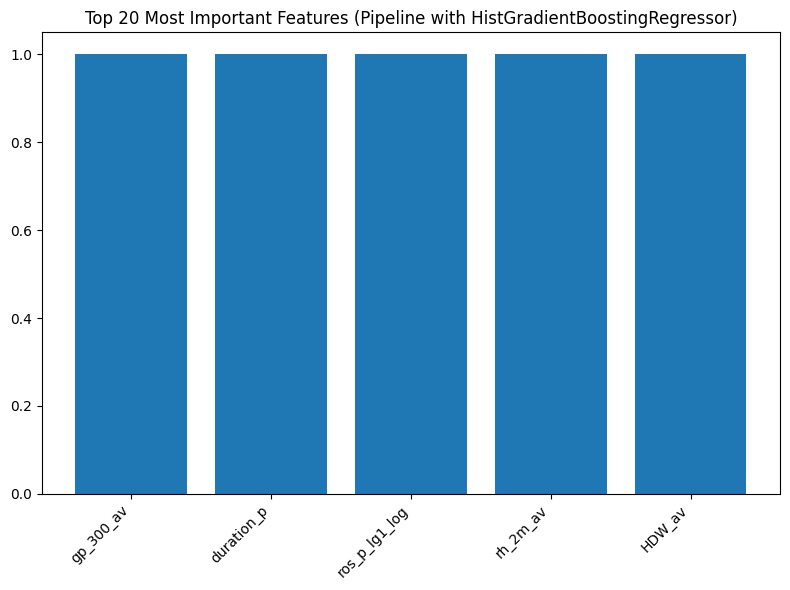


Top 20 Most Important Features (Pipeline with HistGradientBoostingRegressor):
         feature  importance
0      gp_300_av         1.0
1     duration_p         1.0
2  ros_p_lg1_log         1.0
3       rh_2m_av         1.0
4         HDW_av         1.0


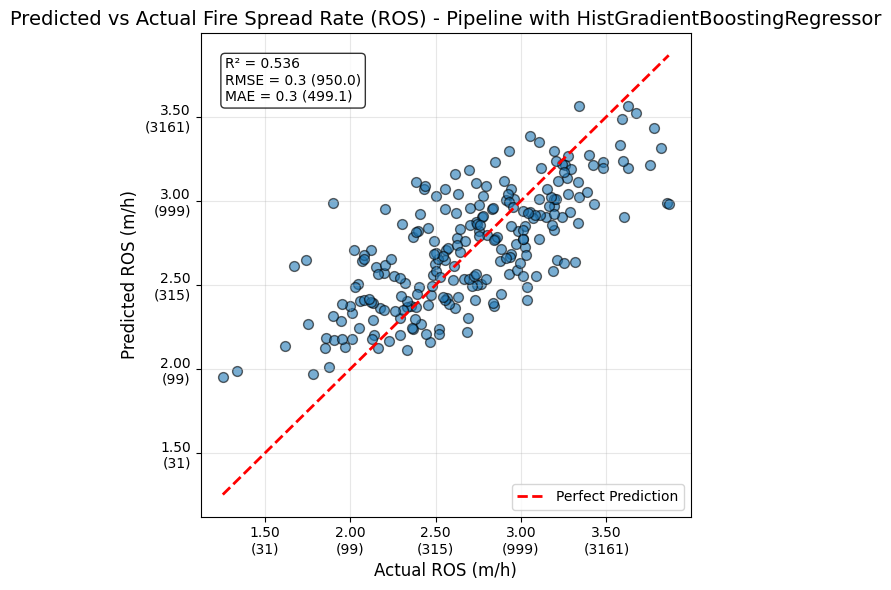

In [46]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Check for NaN values before proceeding
print(f"NaN values in X_train_final: {X_train_final.isna().sum().sum()}")
print(f"NaN values in y_train_log: {y_train_log.isna().sum() if hasattr(y_train_log, 'isna') else np.isnan(y_train_log).sum()}")
print(f"NaN values in X_test_final: {X_test_final.isna().sum().sum()}")

# Parameter distributions for different models
param_dist = {
    'model__alpha': uniform(0.001, 10),               # Regularization strength
    'model__fit_intercept': [True, False],            # Whether to calculate intercept
    'model__max_iter': [1000, 2000, 5000],           # Maximum iterations
    'model__tol': [1e-4, 1e-5, 1e-6],               # Tolerance for stopping
}


param_dist = {
     'max_iter': randint(100, 1000),
     'max_depth': [3, 5, 7, 10, None],
     'learning_rate': uniform(0.01, 0.3),
     'l2_regularization': uniform(0, 2),
     'min_samples_leaf': randint(1, 20),
 }
base_model = HistGradientBoostingRegressor(random_state=42, early_stopping=False)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Halving random search
linear_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model search
print("Starting model training...")
linear_random.fit(X_train_final, y_train_log)

# Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {linear_random.best_params_}")
best_model = linear_random.best_estimator_

# Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Inverse transform log to linear
inv_mult = np.log(log_base) / log_mult
y_test_linear = np.exp(y_test_log * inv_mult) - 1
y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

# Metrics in log space
r2 = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)

# Metrics in linear space
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

# Feature importance/coefficients
feature_names = X_train_final.columns.tolist()

# Extract the actual model from the pipeline if using one
if hasattr(best_model, 'named_steps'):
    final_model = best_model.named_steps['model']
else:
    final_model = best_model

if hasattr(final_model, 'coef_'):
    # For linear models (Ridge, Lasso, ElasticNet)
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(final_model.coef_)
    })
    model_type = type(final_model).__name__
elif hasattr(final_model, 'feature_importances_'):
    # For tree-based models like RandomForest
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    })
    model_type = type(final_model).__name__
else:
    # Fallback
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': [1.0] * len(feature_names)
    })
    model_type = "Pipeline with " + type(final_model).__name__

importances = importances.sort_values('importance', ascending=False)

print("\nLog scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features ({model_type})')
plt.tight_layout()
plt.show()

print(f"\nTop 20 Most Important Features ({model_type}):")
print(importances.head(20))

# If using linear model, also show coefficients with signs
if hasattr(final_model, 'coef_'):
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': final_model.coef_,
        'abs_coefficient': np.abs(final_model.coef_)
    })
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    print(f"\nTop 20 Coefficients ({model_type}):")
    print(coefficients.head(20))

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title(f'Predicted vs Actual Fire Spread Rate (ROS) - {model_type}', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation with both log and linear scales
plt.text(0.05, 0.95, 
    f'R² = {r2:.3f}\n'
    f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
    f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()